###### Reinforcement Learning

umu-id: anth2786

The code is based on code from:
- By Tomas Nordström, with code from Kalle Prorok
- The CartPole environment is from OpenAI's gym: https://gym.openai.com/
- The book: Geron, Hands on maching learning ...


###### Set up the environment

In [1]:
# Select Tensorflow 2.0
# %tensorflow_version 2.x

In [2]:
# Import needed libraries, Keras Tensorflow
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
print('Keras version:',tensorflow.keras.__version__)

# scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Numpy and Pandas
import numpy as np
from numpy import argmax
import pandas as pd

# Helper libraries (system and graph)
import os
import cv2

# More graphing - Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# Random
import random

# Open AI Gym
import gym

TensorFlow version: 2.3.1
Keras version: 2.4.0


# The Main RL Code ##

In [4]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
DISCRETE_STEPS = 10     # discretization steps per state variable (aviod odd numbers), org val = 10

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


# Lab A

#### A. Run the CartPole code 3 runs and make an analysis (below)

###### Run 1

In [6]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)
        
        # Show the simulated environment. A bit difficult to make it work.            
        # env.render()

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward
    
    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

    
print("-------- Done ------------")

Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 10000 x 2
0,8.0
500,10.0
1000,54.0
1500,9.0
2000,12.0
2500,59.0
3000,51.0
3500,68.0
4000,28.0
4500,35.0
5000,81.0
5500,108.0
6000,64.0
6500,36.0
7000,46.0
7500,80.0
8000,33.0
8500,40.0
9000,55.0
9500,55.0
10000,32.0
10500,38.0
11000,65.0
11500,44.0
12000,33.0
12500,76.0
13000,40.0
13500,24.0
14000,37.0
14500,88.0
-------- Done ------------


###### Reward over time

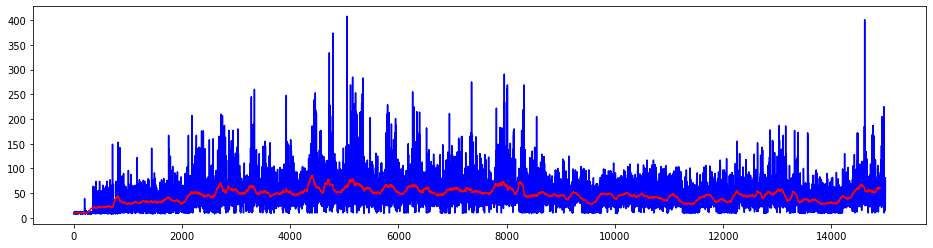

In [7]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r")

###### Run 2

In [8]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)
        
        # Show the simulated environment. A bit difficult to make it work.            
        # env.render()

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward
    
    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

    
print("-------- Done ------------")

Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 10000 x 2
0,10.0
500,20.0
1000,28.0
1500,45.0
2000,103.0
2500,74.0
3000,37.0
3500,33.0
4000,24.0
4500,39.0
5000,26.0
5500,29.0
6000,83.0
6500,51.0
7000,30.0
7500,60.0
8000,24.0
8500,44.0
9000,27.0
9500,11.0
10000,30.0
10500,48.0
11000,34.0
11500,62.0
12000,46.0
12500,43.0
13000,27.0
13500,49.0
14000,35.0
14500,31.0
-------- Done ------------


###### Reward over time

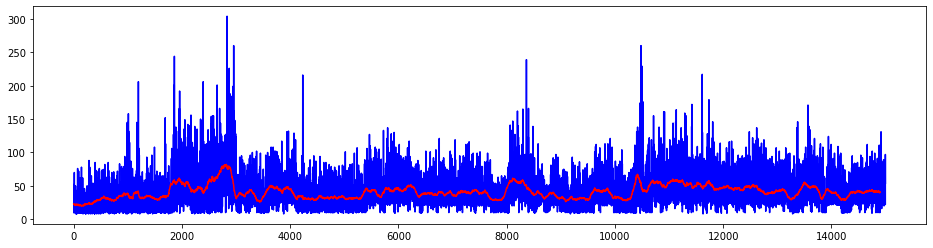

In [9]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r")

###### Run 3

In [10]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)
        
        # Show the simulated environment. A bit difficult to make it work.            
        # env.render()

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward
    
    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')

    
print("-------- Done ------------")

Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 10000 x 2
0,9.0
500,17.0
1000,10.0
1500,17.0
2000,36.0
2500,28.0
3000,23.0
3500,22.0
4000,9.0
4500,232.0
5000,63.0
5500,75.0
6000,46.0
6500,42.0
7000,13.0
7500,42.0
8000,72.0
8500,31.0
9000,45.0
9500,13.0
10000,87.0
10500,63.0
11000,37.0
11500,63.0
12000,42.0
12500,54.0
13000,50.0
13500,70.0
14000,28.0
14500,38.0
-------- Done ------------


###### Reward over time

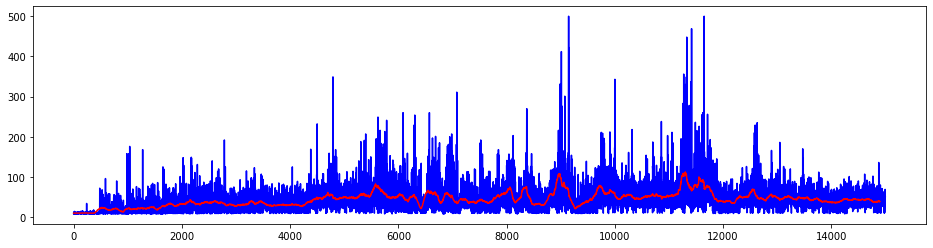

In [11]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r")

#### Analysis

The environment contains the following information:<br>
- state: this is the observation of the cart parameters in a 4 dimension array (below 4 parameters)<br>
- reward: 1 reward per step that is ok<br>
- terminate: Will be set to true when an episode is done. Either by default or by finishing all steps<br>
- info: This is not used in this lab, but can provide additional information<br>
<br>
The 4 parameters that are used to measure the cart are: <br>
- position of the cart<br>
- velocity of the cart<br>
- position of the pole<br>
- velocity of the pole<br>
<br>

The rewards are going up and down over time in all the 3 runs. In the 3ed run, there are peaks up to 500 steps in the reward (good), but it can't keep it stable and it goes down again. The same pattern can be seen in the first run.<br>
<br>
In all of the runs, the average goes up to approx 100, sometime, but are more often lingering around 20-50 rewards (steps). The algorithm is not so good.<br>

#### B. Test with different parameters

In [23]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [24]:
# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 10000 x 2
0,25.0
500,13.0
1000,20.0
1500,11.0
2000,38.0
2500,56.0
3000,81.0
3500,48.0
4000,48.0
4500,20.0
5000,35.0
5500,26.0
6000,24.0
6500,39.0
7000,85.0
7500,69.0
8000,41.0
8500,41.0
9000,15.0
9500,31.0
10000,16.0
10500,44.0
11000,20.0
11500,37.0
12000,26.0
12500,29.0
13000,47.0
13500,38.0
14000,44.0
14500,56.0
15000,45.0
15500,35.0
16000,60.0
16500,27.0
17000,46.0
17500,26.0
18000,10.0
18500,40.0
19000,43.0
19500,31.0
-------- Done ------------
EPISODES: 20000
EPSILON: 0.1
GAMMA: 0.9
LEARNING_RATE: 0.1
DISCRETE_STEPS: 10
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 10000 x 2
0,21.0
500,31.0
1000,51.0
1500,10.0
2000,74.0
2500,12.0
3000,11.0
3500,44.0
4000,21.0
4500,96.0
5000,81.0
5500,58.0
6000,21.0
6500,29.0
7000,32.0
7500,79.0
8000,71.0
8500,47.0
9000,55.0
9500,37.0
10000

1000,10.0
1500,10.0
2000,14.0
2500,30.0
3000,33.0
3500,37.0
4000,33.0
4500,22.0
5000,53.0
5500,61.0
6000,51.0
6500,63.0
7000,55.0
7500,62.0
8000,18.0
8500,45.0
9000,54.0
9500,49.0
10000,75.0
10500,90.0
11000,79.0
11500,62.0
12000,81.0
12500,53.0
13000,79.0
13500,88.0
14000,92.0
14500,77.0
-------- Done ------------
EPISODES: 15000
EPSILON: 0.1
GAMMA: 0.9
LEARNING_RATE: 0.1
DISCRETE_STEPS: 25


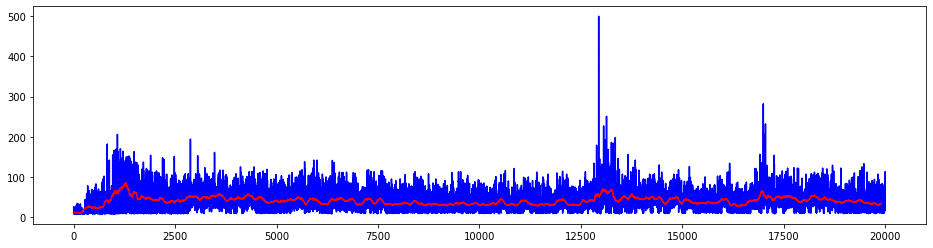

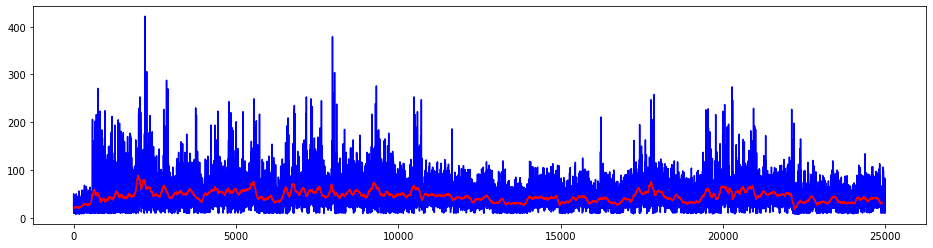

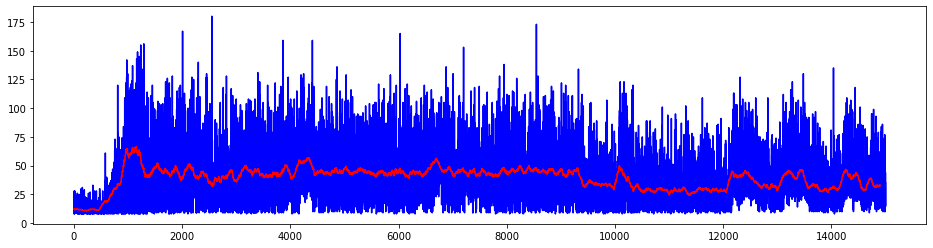

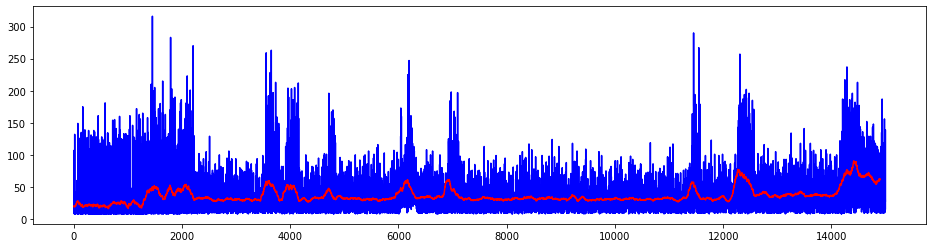

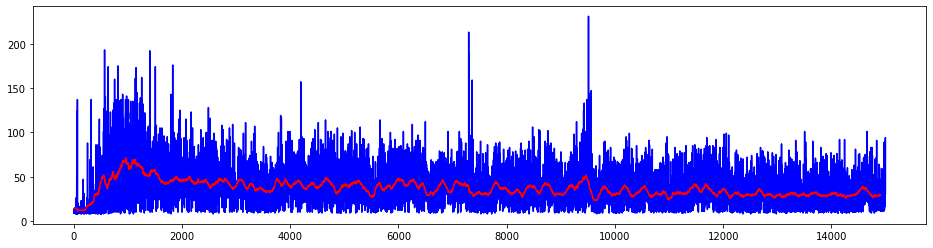

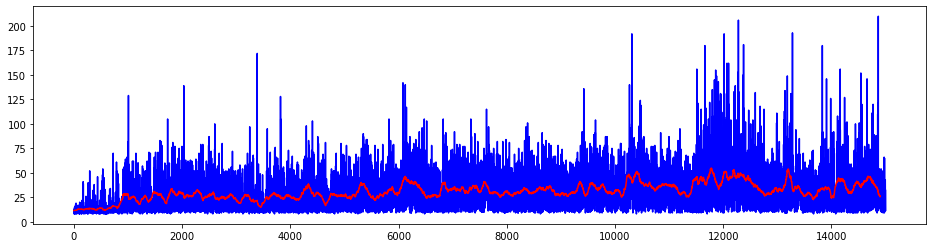

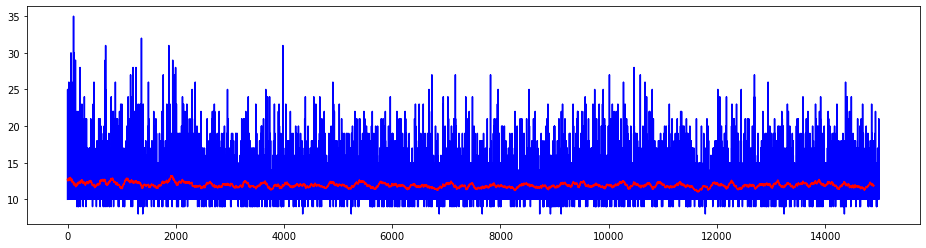

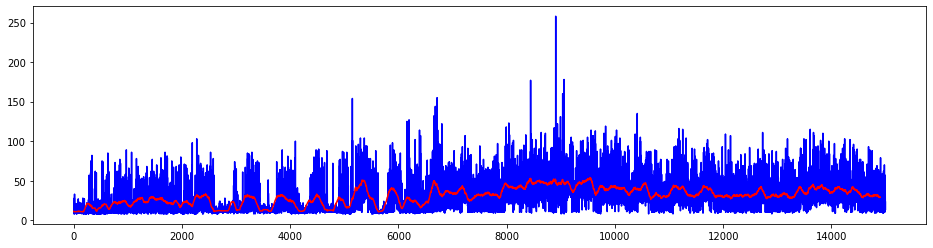

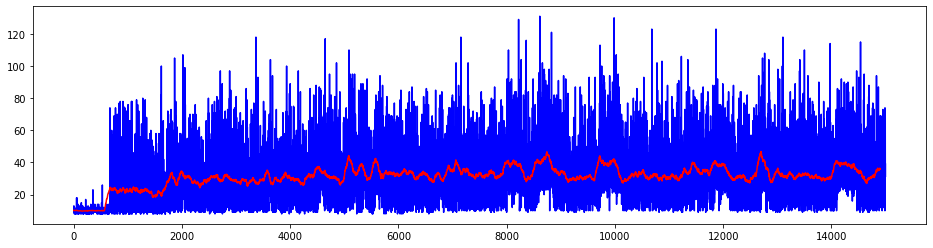

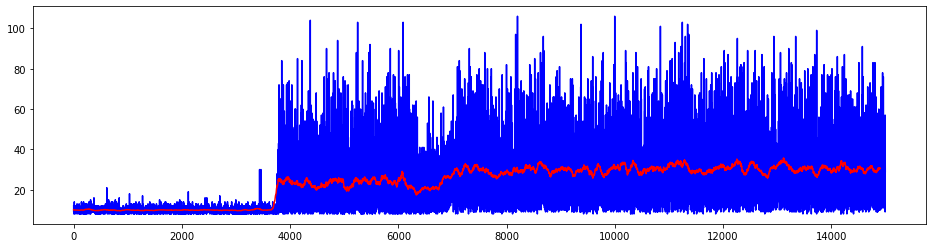

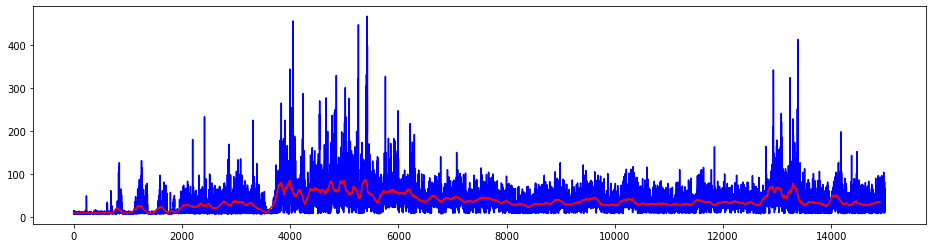

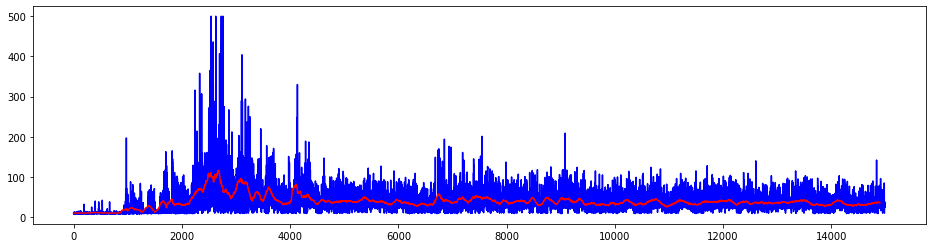

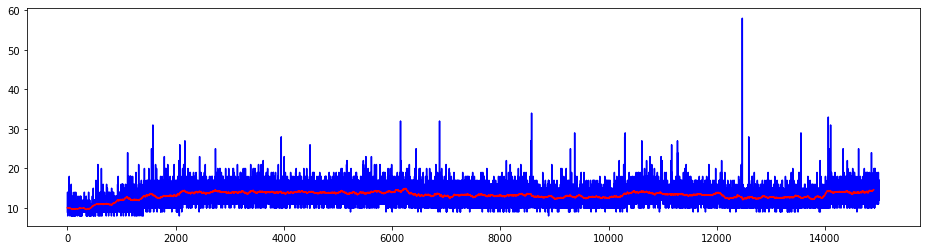

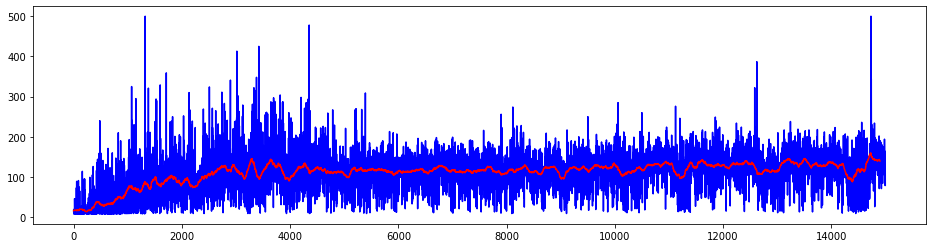

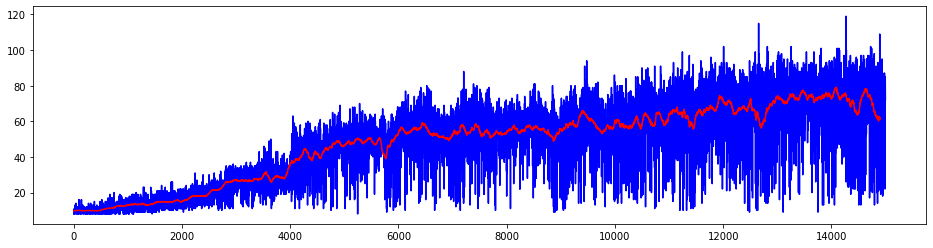

In [26]:
runs = 15
run = 0
while (run < runs):
    run = run + 1
    # A set of parameters that is working well
    EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
    EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
    GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
    LEARNING_RATE  = 0.1    # Learning rate, org val = 0.1
    DISCRETE_STEPS = 10     # discretization steps per state variable (aviod odd numbers), org val = 10

    # *** New code
    if run == 1:
        EPISODES       = 20000
    if run == 2:
        EPISODES       = 25000    
    # Change the greediness
    if run == 3:
        EPSILON        = 0.05
    if run == 4:
        EPSILON        = 0.01
    if run == 5:
        EPSILON        = 0.2
    if run == 6:
        EPSILON        = 0.3
    # Change the reward from the previous setp
    if run == 7:
        GAMMA          = 1.1
    if run == 8:
        GAMMA          = 0.7
    # Change the learning rate - lower
    if run == 9:
        LEARNING_RATE  = 0.05
    if run == 10:
        LEARNING_RATE  = 0.01
    # Change the learning rate - higher
    if run == 11:
        LEARNING_RATE  = 0.15
    if run == 12:
        LEARNING_RATE  = 0.2
    # Increase Discretization steps
    if run == 13:
        DISCRETE_STEPS = 15
    if run == 14:
        DISCRETE_STEPS = 20
    if run == 15:
        DISCRETE_STEPS = 25

    print("-------- Parameters ------------",i)

    print("EPISODES:",EPISODES)
    print("EPSILON:",EPSILON)
    print("GAMMA:",GAMMA)
    print("LEARNING_RATE:",LEARNING_RATE)
    print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
        
        
    # (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
    average_cumulative_reward = 0.0

    episode_reward = np.zeros(EPISODES)
    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))
        

    # Loop over episodes
    # Code to make the training animated
    # https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
    for i in range(EPISODES):
        state4D = env.reset()
        state = make_state(state4D)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            if random.random() < EPSILON:
                action = random.randrange(2)
            else:
                action = greedy_action

            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
        
            # Show the simulated environment. A bit difficult to make it work.            
            # env.render()

            # Update the Q-Table
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LEARNING_RATE * td_error
            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
    
        # Adapt epsilon and learning rate here

        # Per-episode statistics
        if ((i % 500)==0):
          print(i, cumulative_reward, sep=',')

    
    print("-------- Done ------------",i)
    
    # Plot the results from a training run
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r")    

###### Analysis

Above:<br>
Test different parameters to try to achive a reward above 180 on average<br>
We will try out different values for<br>
- episodes: will more episodes stabalize (probably not)<br>
- epsilon: The greediness, the tempo to go from exploring the full spectra, to a small more optimal spectra <br>
- gamma: How much previous steps should be rewarded<br>
- learning rate: Try higher learning rate<br>
- descrete steps: Check higher to make the steps per state higher<br>
    <br>
We can see that:<br>
    - Changing the number of episodes did not make any impact<br>
    - Lower epsilon had a more stable but negative impact, a higher epsilon did also have a negative impact<br>
    - Changing the gamma made the peroformance worse<br>
    - Higher learning rate gave high results now and then, but not consistent. <br>
      Lower learning rate gave worse performance<br>
    - Descrete steps of 20 gave a better performance. 25 (which is odd and should be avoided, gave a incresing curve<br>
      however not with a good performance<br>

###### C. Change over time

Implement a decreasing learing rate with code from Geron<br><br>
Adjusted code from Geron (and other new items) is marked with *** <br>
<br>
We will also use the Descrete step=20 which was best from the earlier run,<br> 
as well as a higher learning rate as it should decay over time in this task

In [12]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [13]:
# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


-------- Parameters ------------
EPISODES: 15000
EPSILON: 0.1
GAMMA: 0.9
LEARNING_RATE: 0.3
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,10.0,0.3
500,16.0,0.08571428571428572
1000,99.0,0.049999999999999996
1500,85.0,0.03529411764705882
2000,63.0,0.02727272727272727
2500,97.0,0.022222222222222223
3000,125.0,0.01875
3500,12.0,0.016216216216216217
4000,54.0,0.014285714285714285
4500,46.0,0.01276595744680851
5000,106.0,0.011538461538461537
5500,53.0,0.010526315789473684
6000,34.0,0.00967741935483871
6500,32.0,0.008955223880597015
7000,79.0,0.008333333333333333
7500,79.0,0.007792207792207792
8000,111.0,0.007317073170731707
8500,147.0,0.006896551724137931
9000,79.0,0.006521739130434782
9500,46.0,0.006185567010309278
10000,119.0,0.0058823529411764705
10500,101.0,0.005607476635514018
11000,73.0,0.005357142857142857
11500,138.0,0.005128205128205128
12000,89.0,0.0049180327868852455

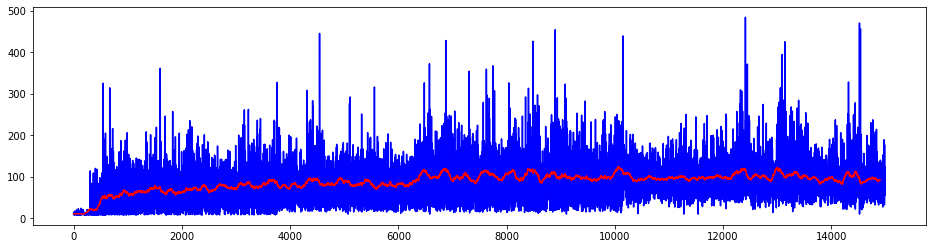

In [15]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

# A set of parameters that is working well
EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
# *** Higher learning rate start
LEARNING_RATE  = 0.3    # Learning rate, org val = 0.1
DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10

print("-------- Parameters ------------")

print("EPISODES:",EPISODES)
print("EPSILON:",EPSILON)
print("GAMMA:",GAMMA)
print("LEARNING_RATE:",LEARNING_RATE)
print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
      
        
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# *** updated code
#alpha0 = 0.05
decay = 0.005
state = 0
    

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
for i in range(EPISODES):
                        
    # Tomas code
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    while not terminate:
        # Compute what the greedy action for the current state is
        qvalues = qtable[state]
        greedy_action = argmax(qvalues)

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)
        
        # Show the simulated environment. A bit difficult to make it work.            
        # env.render()

        # Update the Q-Table
        
        # *** UPDATED CODE (higher learning rate at the start and lower in the end)
        LR = LEARNING_RATE / (1 + i * decay)            
        
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LR * td_error
            
        # Update statistics
        cumulative_reward += reward
        state = next_state

    # store reward for every episode
    episode_reward[i] = cumulative_reward
    
    # Adapt epsilon and learning rate here

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, LR, sep=',')

# *** Updated code
print("---->>>> Check the Q-table (if a vector have 0.0 values, the it is not written below)")
qvaluecount = 0
cnt = 0
for a,b in qtable:
    cnt = cnt + 1
    if a != 0.0 and b != 0.0:
        print ("vector nr:",cnt," values: ",a,",",b)
        qvaluecount = qvaluecount + 1
            
print("Number of vectors in the q table:" , qvaluecount)
    
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r") 
    
print("Average Reward:",y_av)

print("-------- Done ------------")


###### Analysis

We can see that the learning goes up quickly in the beginning with this higher learning rate, and then the reaward average stabilizes

#### Let's look for better parameters with decreasing Learning rate
As higher learning rate gave result we will try even higher rates. We will also try to change how much we should reward previous steps (gamma)

In [16]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [17]:
# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


-------- Parameters ------------
EPISODES: 15000
EPSILON: 0.1
GAMMA: 0.9
LEARNING_RATE: 0.8
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,12.0,0.8
500,114.0,0.2285714285714286
1000,73.0,0.13333333333333333
1500,131.0,0.09411764705882353
2000,117.0,0.07272727272727274
2500,96.0,0.05925925925925926
3000,164.0,0.05
3500,85.0,0.043243243243243246
4000,77.0,0.0380952380952381
4500,214.0,0.03404255319148936
5000,85.0,0.03076923076923077
5500,106.0,0.028070175438596492
6000,60.0,0.025806451612903226
6500,145.0,0.023880597014925373
7000,206.0,0.022222222222222223
7500,102.0,0.02077922077922078
8000,110.0,0.01951219512195122
8500,93.0,0.01839080459770115
9000,76.0,0.017391304347826087
9500,134.0,0.016494845360824743
10000,119.0,0.01568627450980392
10500,168.0,0.014953271028037384
11000,127.0,0.014285714285714287
11500,122.0,0.013675213675213675
12000,107.0,0.013114754098360656
1250

Q-table = 160000 x 2
0,9.0,0.6
500,92.0,0.17142857142857143
1000,79.0,0.09999999999999999
1500,59.0,0.07058823529411765
2000,73.0,0.05454545454545454
2500,34.0,0.044444444444444446
3000,136.0,0.0375
3500,95.0,0.032432432432432434
4000,105.0,0.02857142857142857
4500,98.0,0.02553191489361702
5000,200.0,0.023076923076923075
5500,61.0,0.021052631578947368
6000,166.0,0.01935483870967742
6500,194.0,0.01791044776119403
7000,120.0,0.016666666666666666
7500,152.0,0.015584415584415584
8000,100.0,0.014634146341463414
8500,108.0,0.013793103448275862
9000,114.0,0.013043478260869565
9500,117.0,0.012371134020618556
10000,167.0,0.011764705882352941
10500,77.0,0.011214953271028037
11000,40.0,0.010714285714285714
11500,120.0,0.010256410256410256
12000,139.0,0.009836065573770491
12500,110.0,0.009448818897637795
13000,241.0,0.00909090909090909
13500,164.0,0.00875912408759124
14000,138.0,0.008450704225352112
14500,87.0,0.008163265306122448
---->>>> Check the Q-table (if a vector have 0.0 values, the it is 

Q-table = 160000 x 2
0,26.0,0.5
500,45.0,0.14285714285714285
1000,129.0,0.08333333333333333
1500,98.0,0.058823529411764705
2000,109.0,0.045454545454545456
2500,180.0,0.037037037037037035
3000,121.0,0.03125
3500,105.0,0.02702702702702703
4000,98.0,0.023809523809523808
4500,107.0,0.02127659574468085
5000,139.0,0.019230769230769232
5500,119.0,0.017543859649122806
6000,129.0,0.016129032258064516
6500,166.0,0.014925373134328358
7000,183.0,0.013888888888888888
7500,204.0,0.012987012987012988
8000,117.0,0.012195121951219513
8500,159.0,0.011494252873563218
9000,109.0,0.010869565217391304
9500,153.0,0.010309278350515464
10000,219.0,0.00980392156862745
10500,35.0,0.009345794392523364
11000,142.0,0.008928571428571428
11500,111.0,0.008547008547008548
12000,127.0,0.00819672131147541
12500,128.0,0.007874015748031496
13000,65.0,0.007575757575757576
13500,145.0,0.0072992700729927005
14000,170.0,0.007042253521126761
14500,246.0,0.006802721088435374
---->>>> Check the Q-table (if a vector have 0.0 value

Q-table = 160000 x 2
0,10.0,0.4
500,39.0,0.1142857142857143
1000,115.0,0.06666666666666667
1500,47.0,0.047058823529411764
2000,129.0,0.03636363636363637
2500,123.0,0.02962962962962963
3000,103.0,0.025
3500,32.0,0.021621621621621623
4000,105.0,0.01904761904761905
4500,72.0,0.01702127659574468
5000,73.0,0.015384615384615385
5500,109.0,0.014035087719298246
6000,93.0,0.012903225806451613
6500,64.0,0.011940298507462687
7000,85.0,0.011111111111111112
7500,214.0,0.01038961038961039
8000,98.0,0.00975609756097561
8500,111.0,0.009195402298850575
9000,100.0,0.008695652173913044
9500,117.0,0.008247422680412371
10000,170.0,0.00784313725490196
10500,89.0,0.007476635514018692
11000,85.0,0.0071428571428571435
11500,123.0,0.006837606837606838
12000,74.0,0.006557377049180328
12500,141.0,0.006299212598425198
13000,137.0,0.006060606060606061
13500,87.0,0.005839416058394161
14000,94.0,0.005633802816901409
14500,106.0,0.0054421768707483
---->>>> Check the Q-table (if a vector have 0.0 values, the it is not 

Q-table = 160000 x 2
0,10.0,0.5
500,40.0,0.14285714285714285
1000,89.0,0.08333333333333333
1500,78.0,0.058823529411764705
2000,185.0,0.045454545454545456
2500,129.0,0.037037037037037035
3000,140.0,0.03125
3500,109.0,0.02702702702702703
4000,105.0,0.023809523809523808
4500,164.0,0.02127659574468085
5000,119.0,0.019230769230769232
5500,121.0,0.017543859649122806
6000,154.0,0.016129032258064516
6500,122.0,0.014925373134328358
7000,107.0,0.013888888888888888
7500,106.0,0.012987012987012988
8000,240.0,0.012195121951219513
8500,136.0,0.011494252873563218
9000,153.0,0.010869565217391304
9500,72.0,0.010309278350515464
10000,114.0,0.00980392156862745
10500,131.0,0.009345794392523364
11000,125.0,0.008928571428571428
11500,190.0,0.008547008547008548
12000,137.0,0.00819672131147541
12500,197.0,0.007874015748031496
13000,196.0,0.007575757575757576
13500,153.0,0.0072992700729927005
14000,122.0,0.007042253521126761
14500,143.0,0.006802721088435374
---->>>> Check the Q-table (if a vector have 0.0 valu

Q-table = 160000 x 2
0,9.0,0.5
500,25.0,0.14285714285714285
1000,98.0,0.08333333333333333
1500,86.0,0.058823529411764705
2000,197.0,0.045454545454545456
2500,123.0,0.037037037037037035
3000,101.0,0.03125
3500,152.0,0.02702702702702703
4000,189.0,0.023809523809523808
4500,202.0,0.02127659574468085
5000,196.0,0.019230769230769232
5500,118.0,0.017543859649122806
6000,116.0,0.016129032258064516
6500,138.0,0.014925373134328358
7000,136.0,0.013888888888888888
7500,24.0,0.012987012987012988
8000,138.0,0.012195121951219513
8500,147.0,0.011494252873563218
9000,149.0,0.010869565217391304
9500,119.0,0.010309278350515464
10000,130.0,0.00980392156862745
10500,157.0,0.009345794392523364
11000,160.0,0.008928571428571428
11500,118.0,0.008547008547008548
12000,279.0,0.00819672131147541
12500,194.0,0.007874015748031496
13000,243.0,0.007575757575757576
13500,166.0,0.0072992700729927005
14000,145.0,0.007042253521126761
14500,183.0,0.006802721088435374
---->>>> Check the Q-table (if a vector have 0.0 value

Q-table = 160000 x 2
0,12.0,0.5
500,52.0,0.14285714285714285
1000,83.0,0.08333333333333333
1500,114.0,0.058823529411764705
2000,98.0,0.045454545454545456
2500,123.0,0.037037037037037035
3000,11.0,0.03125
3500,230.0,0.02702702702702703
4000,129.0,0.023809523809523808
4500,183.0,0.02127659574468085
5000,111.0,0.019230769230769232
5500,135.0,0.017543859649122806
6000,160.0,0.016129032258064516
6500,118.0,0.014925373134328358
7000,29.0,0.013888888888888888
7500,211.0,0.012987012987012988
8000,41.0,0.012195121951219513
8500,38.0,0.011494252873563218
9000,178.0,0.010869565217391304
9500,204.0,0.010309278350515464
10000,263.0,0.00980392156862745
10500,271.0,0.009345794392523364
11000,128.0,0.008928571428571428
11500,134.0,0.008547008547008548
12000,190.0,0.00819672131147541
12500,183.0,0.007874015748031496
13000,131.0,0.007575757575757576
13500,306.0,0.0072992700729927005
14000,266.0,0.007042253521126761
14500,143.0,0.006802721088435374
---->>>> Check the Q-table (if a vector have 0.0 values,

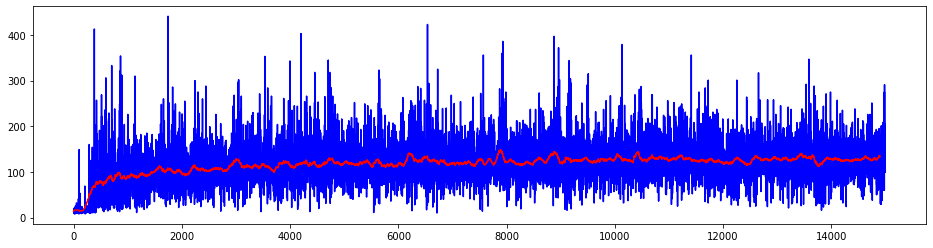

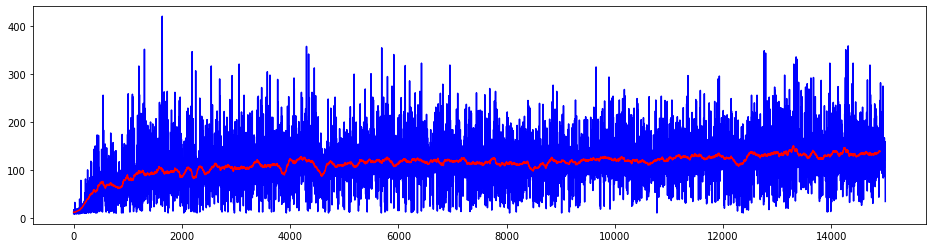

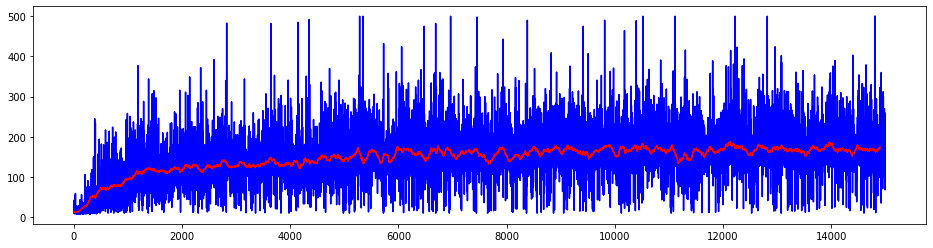

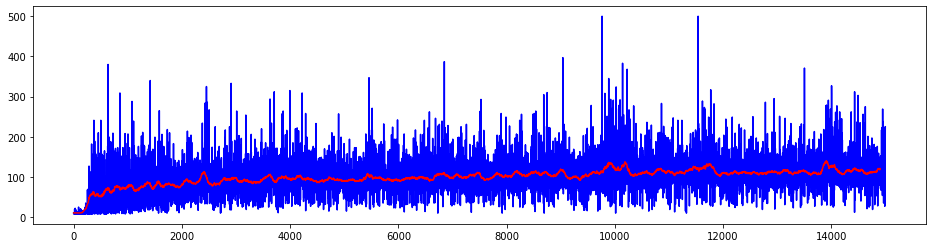

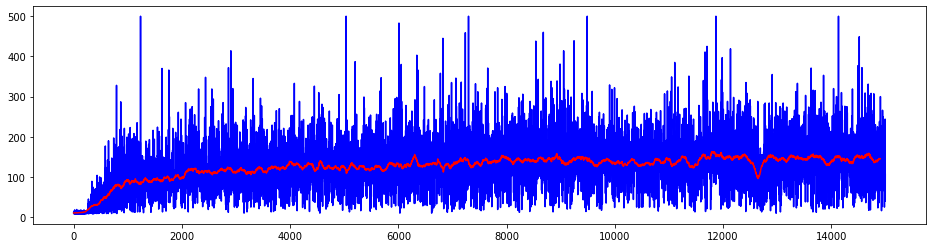

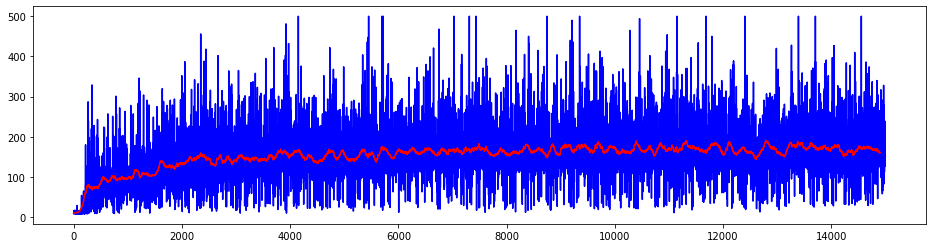

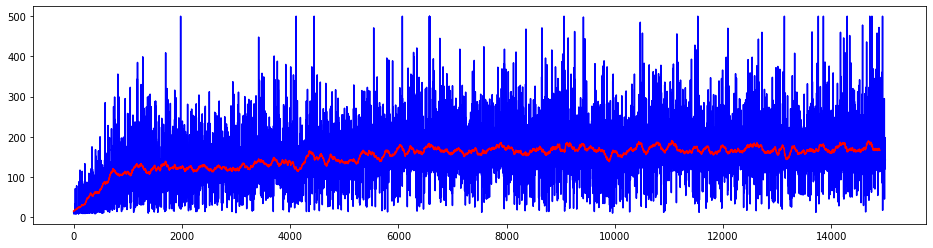

In [19]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

runs = 7
run = 0
while (run < runs):
    run = run + 1
    # A set of parameters that is working well
    EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
    EPSILON        = 0.1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
    GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
    
    # *** UPDATED - NEW HIGH LEARNING RATE as it will decrease
    LEARNING_RATE  = 0.5    # Learning rate, org val = 0.1
    # *** Use the best discrete_Steps from B
    DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10

    # *** Updated code
    if run == 1:
        LEARNING_RATE  = 0.8
    if run == 2:
        LEARNING_RATE  = 0.6
    if run == 3:
        LEARNING_RATE  = 0.5
    if run == 4:
        LEARNING_RATE  = 0.4
    if run == 5:
        GAMMA          = 0.92
    if run == 6:
        GAMMA          = 0.95
    if run == 7:
        GAMMA          = 0.98
    
    print("-------- Parameters ------------")

    print("EPISODES:",EPISODES)
    print("EPSILON:",EPSILON)
    print("GAMMA:",GAMMA)
    print("LEARNING_RATE:",LEARNING_RATE)
    print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
        
        
    # (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
    average_cumulative_reward = 0.0

    episode_reward = np.zeros(EPISODES)
    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Geron code
    #alpha0 = 0.05
    decay = 0.005
    # gamma = 0.9
    state = 0
    

    # Loop over episodes
    # Code to make the training animated
    # https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
    for i in range(EPISODES):
                        
        # Tomas code
        state4D = env.reset()
        state = make_state(state4D)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            if random.random() < EPSILON:
                action = random.randrange(2)
            else:
                action = greedy_action

            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
        
            # Show the simulated environment. A bit difficult to make it work.            
            # env.render()

            # Update the Q-Table - *** UPDATED CODE ***
            LR = LEARNING_RATE / (1 + i * decay)            
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LR * td_error
            
            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
    
        # Adapt epsilon and learning rate here

        # Per-episode statistics
        if ((i % 500)==0):
          print(i, cumulative_reward, LR, sep=',')

    # *** Updated
    print("---->>>> Check the Q-table (if a vector have 0.0 values, the it is not written below)")
    qvaluecount = 0
    cnt = 0
    for a,b in qtable:
        cnt = cnt + 1
        if a != 0.0 and b != 0.0:
            print ("vector nr:",cnt," values: ",a,",",b)
            qvaluecount = qvaluecount + 1
            
    print("Number of vectors in the q table:" , qvaluecount)
    print("-------- Done ------------")
    
    # Plot the results from a training run
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r") 
    
    print("Average:",y_av)
    

###### Analysis

Looking at the reward figures, we have now come up with better figures<br>
Average: [ 13.74  13.75  13.73 ... 134.86 134.73 134.03]<br>
Average: [ 11.34  11.35  11.32 ... 139.35 139.42 138.32]<br>
Average: [ 13.39  13.24  13.19 ... 173.63 173.74 173.84]<br>
Average: [ 10.63  10.63  10.66 ... 118.68 119.49 120.76]<br>
Average: [ 10.48  10.48  10.48 ... 145.85 144.91 145.07]<br>
Average: [ 14.73  14.71  14.74 ... 167.08 166.95 166.45]<br>
Average: [ 10.68  10.69  10.72 ... 160.58 160.64 160.6 ]<br>
<br>
The gamma change made as significant impact on the rewards. 0.95 and 0.98 gave pretty good results. Also a learning rate start of 0.5 gave a good result. However the results could be "one-off"<br>



###### And with epsilon greedy policy

We will make the previous run, but now with greedy epsilon (more often go with optimal/max, than random choice)
<br><br>

In [20]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [21]:
# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


-------- Parameters ------------
EPISODES: 15000
EPSILON: 1
GAMMA: 0.9
LEARNING_RATE: 0.8
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,18.0,0.8,1.0
500,38.0,0.64,0.8
1000,33.0,0.5333333333333333,0.6666666666666666
1500,92.0,0.4571428571428572,0.5714285714285714
2000,58.0,0.4,0.5
2500,160.0,0.35555555555555557,0.4444444444444444
3000,144.0,0.32,0.4
3500,21.0,0.29090909090909095,0.36363636363636365
4000,115.0,0.26666666666666666,0.3333333333333333
4500,17.0,0.24615384615384617,0.3076923076923077
5000,93.0,0.2285714285714286,0.2857142857142857
5500,40.0,0.21333333333333335,0.26666666666666666
6000,270.0,0.2,0.25
6500,214.0,0.18823529411764706,0.23529411764705882
7000,310.0,0.17777777777777778,0.2222222222222222
7500,204.0,0.16842105263157894,0.21052631578947367
8000,417.0,0.16,0.2
8500,264.0,0.1523809523809524,0.19047619047619047
9000,328.0,0.14545454545454548,0.181818181818

vector nr: 75413  values:  3.2213116827197457 , 8.41590273835682
vector nr: 75430  values:  1.8833745138145541 , 1.1403159321094254
vector nr: 75431  values:  9.167085971891927 , 9.792036995188921
vector nr: 75432  values:  8.54656556895498 , 9.311758725213288
vector nr: 75433  values:  3.1487581141297794 , 7.708186768217
vector nr: 75451  values:  8.148670257007698 , 7.758914547729576
vector nr: 75452  values:  7.14690672684142 , 8.775174281646535
vector nr: 75453  values:  2.7088008130633257 , 4.1460216665330245
vector nr: 75471  values:  4.945169923969991 , 8.301584337665224
vector nr: 75472  values:  4.119469539274322 , 6.478417133730371
vector nr: 75473  values:  1.9001193722004308 , 2.5874843277716995
vector nr: 75491  values:  1.9290836849014765 , 4.063907934546919
vector nr: 75492  values:  1.7719222373170092 , 1.9715299180447015
vector nr: 75493  values:  1.0000000000000002 , 0.9999999999999665
vector nr: 75709  values:  3.379314737375107 , 1.4891846199946062
vector nr: 75710 

vector nr: 107452  values:  0.47332603025378006 , 3.0389249597520833
vector nr: 107453  values:  2.1081948981806664 , 0.5104073448653644
vector nr: 107473  values:  0.43211170233592566 , 1.7080695346278514
vector nr: 107492  values:  0.6889616579039942 , 0.10540878845773767
vector nr: 107493  values:  0.9993053647282306 , 0.1638001638001638
vector nr: 107710  values:  4.141933166395032 , 1.6903390169936579
vector nr: 107711  values:  1.5024715223053173 , 4.735502675897589
vector nr: 107730  values:  9.025011287709873 , 4.158140102023796
vector nr: 107731  values:  8.911452376685899 , 6.1774473617605
vector nr: 107732  values:  1.069496653052692 , 1.2633163247297814
vector nr: 107750  values:  9.21206840995411 , 8.875472878905713
vector nr: 107751  values:  9.520299456579911 , 9.694645114866635
vector nr: 107752  values:  4.767069257393825 , 3.7611691834140544
vector nr: 107770  values:  9.83121625435276 , 9.79482308708947
vector nr: 107771  values:  9.676390005977748 , 9.83473498752219

500,13.0,0.48,0.8
1000,12.0,0.39999999999999997,0.6666666666666666
1500,13.0,0.34285714285714286,0.5714285714285714
2000,74.0,0.3,0.5
2500,84.0,0.26666666666666666,0.4444444444444444
3000,39.0,0.24,0.4
3500,43.0,0.21818181818181817,0.36363636363636365
4000,211.0,0.19999999999999998,0.3333333333333333
4500,208.0,0.1846153846153846,0.3076923076923077
5000,91.0,0.17142857142857143,0.2857142857142857
5500,83.0,0.16,0.26666666666666666
6000,123.0,0.15,0.25
6500,150.0,0.1411764705882353,0.23529411764705882
7000,203.0,0.13333333333333333,0.2222222222222222
7500,254.0,0.12631578947368421,0.21052631578947367
8000,227.0,0.12,0.2
8500,333.0,0.11428571428571428,0.19047619047619047
9000,261.0,0.10909090909090909,0.18181818181818182
9500,152.0,0.10434782608695652,0.17391304347826086
10000,165.0,0.09999999999999999,0.16666666666666666
10500,125.0,0.096,0.16
11000,262.0,0.0923076923076923,0.15384615384615385
11500,441.0,0.08888888888888889,0.14814814814814814
12000,209.0,0.08571428571428572,0.14285714

vector nr: 83890  values:  4.368241090063826 , 1.1252695786896476
vector nr: 83891  values:  3.2414387628506565 , 6.718893206531517
vector nr: 83892  values:  1.284947014901034 , 1.6924689430786541
vector nr: 83893  values:  0.8414391300145321 , 0.4401083028033431
vector nr: 84109  values:  3.016141681097895 , 1.6697847413100293
vector nr: 84110  values:  5.357750246292479 , 5.339854936865623
vector nr: 84111  values:  9.71751974019662 , 5.657599984017327
vector nr: 84129  values:  7.264153072560916 , 4.662877921189628
vector nr: 84130  values:  9.46222981171664 , 8.681120856390647
vector nr: 84131  values:  9.89839202250542 , 9.492716772707334
vector nr: 84149  values:  9.332389697997934 , 8.339015783684196
vector nr: 84150  values:  9.868329829416426 , 9.804499553083787
vector nr: 84151  values:  9.939234610125808 , 9.928990530723475
vector nr: 84152  values:  2.7350205400970817 , 0.8194625721295046
vector nr: 84169  values:  9.922400133700494 , 9.401700773255428
vector nr: 84170  va

Average: [ 21.67  21.7   21.6  ... 288.4  290.82 289.83]
-------- Parameters ------------
EPISODES: 15000
EPSILON: 1
GAMMA: 0.9
LEARNING_RATE: 0.5
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,33.0,0.5,1.0
500,25.0,0.4,0.8
1000,56.0,0.3333333333333333,0.6666666666666666
1500,87.0,0.2857142857142857,0.5714285714285714
2000,38.0,0.25,0.5
2500,104.0,0.2222222222222222,0.4444444444444444
3000,84.0,0.2,0.4
3500,206.0,0.18181818181818182,0.36363636363636365
4000,66.0,0.16666666666666666,0.3333333333333333
4500,184.0,0.15384615384615385,0.3076923076923077
5000,36.0,0.14285714285714285,0.2857142857142857
5500,137.0,0.13333333333333333,0.26666666666666666
6000,199.0,0.125,0.25
6500,61.0,0.11764705882352941,0.23529411764705882
7000,121.0,0.1111111111111111,0.2222222222222222
7500,98.0,0.10526315789473684,0.21052631578947367
8000,142.0,0.1,0.2
8500,500.0,0.09523809523809523,0.1904761

vector nr: 75709  values:  3.466175648046876 , 1.6070197699314712
vector nr: 75710  values:  7.777119974170928 , 5.567062468773845
vector nr: 75711  values:  9.439728922069577 , 8.554222926627308
vector nr: 75729  values:  7.464456409777359 , 4.366965413842612
vector nr: 75730  values:  9.470241575357825 , 9.143113731340879
vector nr: 75731  values:  9.73859524079829 , 9.693373189718674
vector nr: 75749  values:  9.587199235222753 , 5.613400976259028
vector nr: 75750  values:  9.942755663029141 , 9.862765725979477
vector nr: 75751  values:  9.967642435936712 , 9.954151393559659
vector nr: 75752  values:  9.93810385621988 , 3.3646146855236068
vector nr: 75769  values:  9.569634810060563 , 5.150629345173188
vector nr: 75770  values:  9.988603475101833 , 9.97227217060733
vector nr: 75771  values:  9.981552233900686 , 9.988595335582573
vector nr: 75772  values:  9.943955011910779 , 9.993084259790285
vector nr: 75789  values:  9.253649708152714 , 2.88523937840534
vector nr: 75790  values:  

vector nr: 108570  values:  6.283324724223943 , 5.153525029168901
vector nr: 108571  values:  0.36972370628985657 , 3.164748667857742
vector nr: 108589  values:  5.685868558774645 , 0.33387416505293666
vector nr: 108590  values:  7.152177758038921 , 5.985728124356917
vector nr: 108591  values:  5.657844665305292 , 0.35994979905699626
vector nr: 108610  values:  7.681342600883513 , 7.276050635302808
vector nr: 108611  values:  7.323888297932552 , 5.446052543321549
vector nr: 108612  values:  3.0074551954530224 , 0.4640873786629753
vector nr: 108630  values:  8.016204413696473 , 7.762939457468564
vector nr: 108631  values:  7.7870405876487 , 8.106163007143632
vector nr: 108632  values:  4.680273097578414 , 0.5098897434958877
vector nr: 108650  values:  6.533461262444508 , 7.972423926372476
vector nr: 108651  values:  7.226625513870772 , 7.813955515030547
vector nr: 108652  values:  4.190880444691512 , 1.7404995242999428
vector nr: 108670  values:  7.184225148387134 , 5.221755443994848
ve

vector nr: 83852  values:  7.287701400730119 , 8.614452056626583
vector nr: 83871  values:  6.960477359726675 , 8.203456959724244
vector nr: 83872  values:  4.906010641191663 , 7.0046246413555515
vector nr: 83891  values:  3.4884464867600378 , 4.8453709182036055
vector nr: 83892  values:  1.6152800936512286 , 3.9390180220243822
vector nr: 83893  values:  0.23930601256356568 , 0.38524772997996637
vector nr: 84109  values:  4.118256649596477 , 2.097267378192118
vector nr: 84110  values:  6.612891603134848 , 4.8433639304093905
vector nr: 84111  values:  9.714426454645226 , 4.322586577345817
vector nr: 84129  values:  6.848149749833574 , 5.290523120109758
vector nr: 84130  values:  9.491975741113887 , 8.984062537197518
vector nr: 84131  values:  9.880687481033224 , 9.346818691443678
vector nr: 84149  values:  9.422519216840762 , 8.019982532737426
vector nr: 84150  values:  9.938824760663213 , 9.769572618983439
vector nr: 84151  values:  9.954589625227097 , 9.878870210135613
vector nr: 8416

Q-table = 160000 x 2
0,21.0,0.5,1.0
500,33.0,0.4,0.8
1000,33.0,0.3333333333333333,0.6666666666666666
1500,70.0,0.2857142857142857,0.5714285714285714
2000,33.0,0.25,0.5
2500,102.0,0.2222222222222222,0.4444444444444444
3000,75.0,0.2,0.4
3500,128.0,0.18181818181818182,0.36363636363636365
4000,148.0,0.16666666666666666,0.3333333333333333
4500,119.0,0.15384615384615385,0.3076923076923077
5000,39.0,0.14285714285714285,0.2857142857142857
5500,133.0,0.13333333333333333,0.26666666666666666
6000,33.0,0.125,0.25
6500,215.0,0.11764705882352941,0.23529411764705882
7000,19.0,0.1111111111111111,0.2222222222222222
7500,60.0,0.10526315789473684,0.21052631578947367
8000,323.0,0.1,0.2
8500,119.0,0.09523809523809523,0.19047619047619047
9000,500.0,0.09090909090909091,0.18181818181818182
9500,229.0,0.08695652173913043,0.17391304347826086
10000,243.0,0.08333333333333333,0.16666666666666666
10500,500.0,0.08,0.16
11000,327.0,0.07692307692307693,0.15384615384615385
11500,242.0,0.07407407407407407,0.148148148148

vector nr: 76109  values:  4.126312811952608 , 1.6493911233517273
vector nr: 76110  values:  6.13411404169644 , 3.336635232288059
vector nr: 76129  values:  8.27238000088814 , 4.718918787070548
vector nr: 76130  values:  11.158983791140653 , 9.176634395607962
vector nr: 76131  values:  12.129038534557832 , 2.0929061868902132
vector nr: 76149  values:  10.900150993524973 , 10.22216901483295
vector nr: 76150  values:  12.303595810571931 , 12.02515119654703
vector nr: 76151  values:  11.533014741790094 , 12.313566769880463
vector nr: 76169  values:  12.401724918273434 , 11.739390455849726
vector nr: 76170  values:  12.46826207677913 , 12.383970649599416
vector nr: 76171  values:  12.489327805909017 , 12.46199621719011
vector nr: 76189  values:  12.481454684695281 , 12.394077974680377
vector nr: 76190  values:  12.494063509740625 , 12.487024473149724
vector nr: 76191  values:  12.493559997856698 , 12.491026694929042
vector nr: 76209  values:  12.491121337548021 , 12.422176567398063
vector 

vector nr: 108909  values:  1.109739871775025 , 0.5099608065872859
vector nr: 108910  values:  0.7009093053922572 , 0.22668813759851822
vector nr: 108929  values:  2.1502013170244876 , 0.4734937790956161
vector nr: 108949  values:  2.7601046600672907 , 0.7039300757308041
vector nr: 108969  values:  1.2570802966526589 , 3.235848960873374
vector nr: 108970  values:  0.7895569458212146 , 3.216634366357589
vector nr: 108989  values:  5.5148434931475405 , 1.7442001447032023
vector nr: 108990  values:  0.9199572959112408 , 4.969303409628065
vector nr: 109009  values:  6.0633270353803885 , 0.30289178324996674
vector nr: 109010  values:  8.100259876200605 , 4.082371850909577
vector nr: 109011  values:  3.4468420125161376 , 0.43235066070773265
vector nr: 109029  values:  5.62681929791684 , 1.948718063681968
vector nr: 109030  values:  9.023942932309561 , 6.942621484309414
vector nr: 109031  values:  6.472846287999482 , 1.037486036531421
vector nr: 109049  values:  5.122217156444301 , 1.84289859

vector nr: 76670  values:  19.855932438571237 , 19.480516007077682
vector nr: 76689  values:  7.210243688359387 , 3.04531515041956
vector nr: 76690  values:  19.326248682930075 , 13.863180246949542
vector nr: 82653  values:  0.19554165037152915 , 0.12380820696882916
vector nr: 82910  values:  11.850969237220845 , 0.9807157004972197
vector nr: 82911  values:  10.678392006641262 , 16.056543533479836
vector nr: 82931  values:  6.669335796761993 , 17.718703756221043
vector nr: 82932  values:  0.7988550422400784 , 7.943500567523234
vector nr: 82951  values:  3.944099316124421 , 1.374946519482611
vector nr: 82952  values:  4.853721605684688 , 1.482411925885879
vector nr: 82972  values:  6.323871081743008 , 0.6894581233693957
vector nr: 82992  values:  4.193823872610432 , 3.7572710003273184
vector nr: 83012  values:  0.9898404425921243 , 7.272178297077907
vector nr: 83032  values:  1.2211638581578275 , 4.374543695751263
vector nr: 83033  values:  0.2739192756273012 , 1.4067392922115558
vector

vector nr: 108610  values:  16.60800036605315 , 16.556203222499807
vector nr: 108611  values:  17.21761695678721 , 13.087579150750054
vector nr: 108630  values:  16.144384997884572 , 15.757598635828536
vector nr: 108631  values:  14.944498384111276 , 15.29421143979664
vector nr: 108632  values:  2.091951276728728 , 0.21123785382340515
vector nr: 108649  values:  12.973383508970983 , 1.0998567813542761
vector nr: 108650  values:  14.050157908719909 , 15.200630447167894
vector nr: 108651  values:  13.22399443759648 , 14.526634426455255
vector nr: 108652  values:  0.6509729745099101 , 4.799543917719592
vector nr: 108669  values:  6.39955308409592 , 0.0694637399277577
vector nr: 108670  values:  12.284313950317394 , 11.294868857973832
vector nr: 108671  values:  10.724013202837494 , 11.609805066761702
vector nr: 108672  values:  3.4003516064450383 , 0.6438275594015503
vector nr: 108690  values:  8.936417304071018 , 11.274300920982725
vector nr: 108691  values:  7.027241832500205 , 9.511636

Q-table = 160000 x 2
0,16.0,0.5,1.0
500,25.0,0.4,0.8
1000,27.0,0.3333333333333333,0.6666666666666666
1500,41.0,0.2857142857142857,0.5714285714285714
2000,29.0,0.25,0.5
2500,42.0,0.2222222222222222,0.4444444444444444
3000,76.0,0.2,0.4
3500,27.0,0.18181818181818182,0.36363636363636365
4000,53.0,0.16666666666666666,0.3333333333333333
4500,46.0,0.15384615384615385,0.3076923076923077
5000,79.0,0.14285714285714285,0.2857142857142857
5500,277.0,0.13333333333333333,0.26666666666666666
6000,331.0,0.125,0.25
6500,500.0,0.11764705882352941,0.23529411764705882
7000,215.0,0.1111111111111111,0.2222222222222222
7500,231.0,0.10526315789473684,0.21052631578947367
8000,65.0,0.1,0.2
8500,500.0,0.09523809523809523,0.19047619047619047
9000,166.0,0.09090909090909091,0.18181818181818182
9500,500.0,0.08695652173913043,0.17391304347826086
10000,500.0,0.08333333333333333,0.16666666666666666
10500,313.0,0.08,0.16
11000,297.0,0.07692307692307693,0.15384615384615385
11500,468.0,0.07407407407407407,0.14814814814814

vector nr: 75751  values:  46.44816061726515 , 45.94956800967286
vector nr: 75752  values:  48.09558056610283 , 38.62097715791461
vector nr: 75769  values:  45.27084752953061 , 14.37876880401921
vector nr: 75770  values:  47.78957184254967 , 47.04606060328025
vector nr: 75771  values:  48.7149991982198 , 47.88652566341604
vector nr: 75772  values:  48.642730283026076 , 48.773793738595494
vector nr: 75789  values:  47.67426686606845 , 24.34131688952353
vector nr: 75790  values:  48.840553518006416 , 48.47417638751488
vector nr: 75791  values:  48.92385818628607 , 48.62107630486618
vector nr: 75792  values:  48.765858535154635 , 48.81644308731504
vector nr: 75809  values:  47.57121302453525 , 16.142833331363654
vector nr: 75810  values:  48.99968630347172 , 48.8025953237652
vector nr: 75811  values:  48.77295615480378 , 49.02211962540329
vector nr: 75812  values:  48.03473821335446 , 48.867313558398294
vector nr: 75829  values:  32.923791290338805 , 8.565107971788152
vector nr: 75830  va

vector nr: 108129  values:  3.7585075689564316 , 0.37970681471284223
vector nr: 108130  values:  9.435980000021138 , 4.672045442486696
vector nr: 108131  values:  24.18537583754637 , 4.285520807548159
vector nr: 108149  values:  10.067905378908025 , 0.9360147798080092
vector nr: 108150  values:  35.04593749641676 , 31.360890353642404
vector nr: 108151  values:  36.56094829917494 , 30.88861940324395
vector nr: 108169  values:  22.531003131641853 , 4.144333189386536
vector nr: 108170  values:  38.584094695957255 , 37.48718210777251
vector nr: 108171  values:  37.14333491316232 , 36.41439901328584
vector nr: 108172  values:  10.78658439298582 , 2.5687134155980202
vector nr: 108189  values:  22.33931541269583 , 1.125119194719521
vector nr: 108190  values:  34.76359940734082 , 33.901274468630604
vector nr: 108191  values:  32.164755405692475 , 33.34317287606556
vector nr: 108192  values:  5.43991494142859 , 20.022903212489307
vector nr: 108209  values:  12.528789635434695 , 1.22875787666995

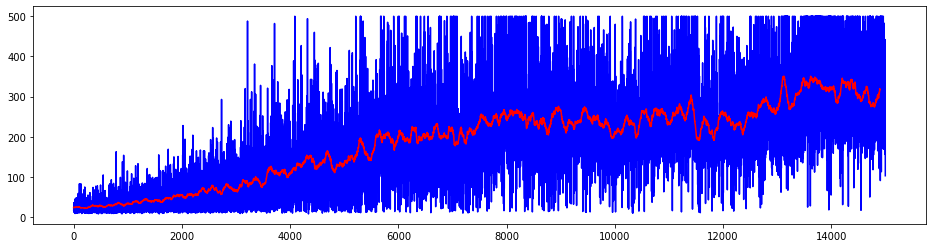

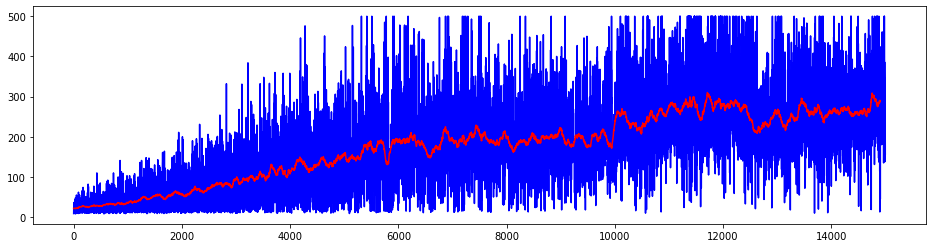

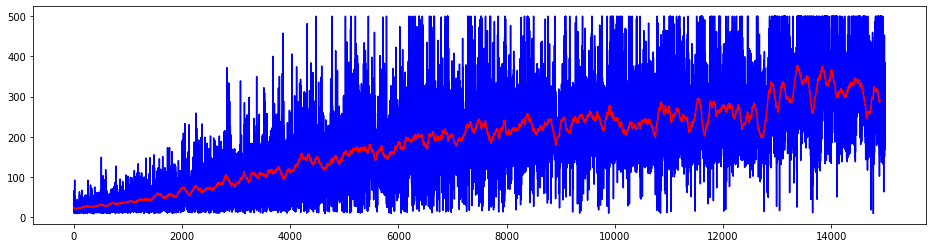

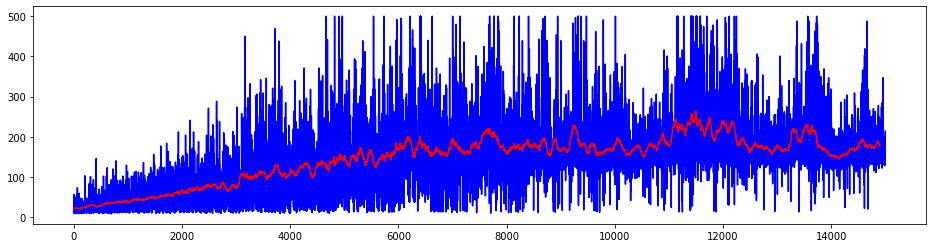

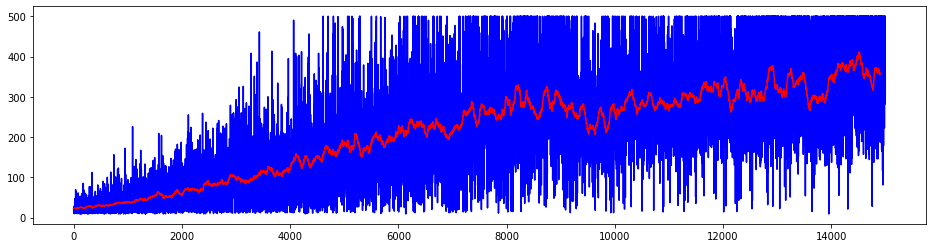

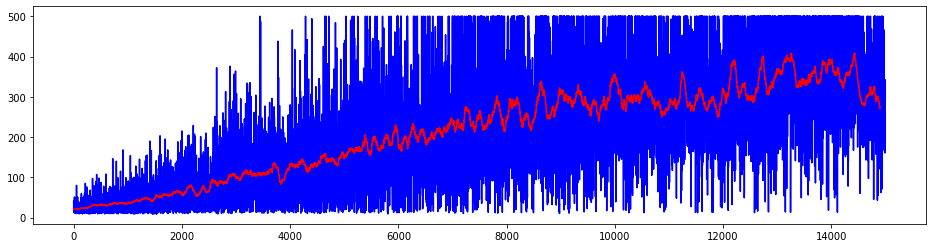

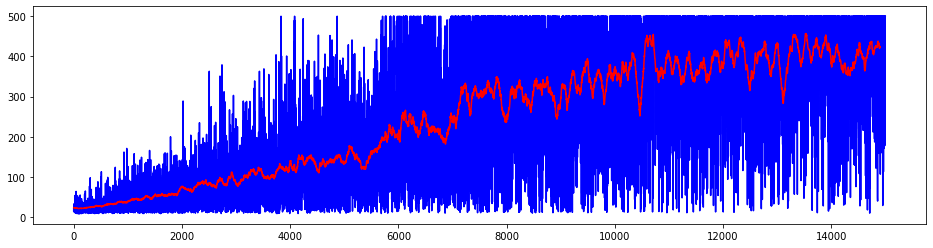

In [23]:
runs = 7
run = 0
while (run < runs):
    run = run + 1
    # A set of parameters that is working well
    EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
    DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10
    
    # Start with high EPSILON (and decreas in the code)
    EPSILON        = 1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
    # These are "earlier best" and changed per run
    GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9   
    LEARNING_RATE  = 0.5    # Learning rate, org val = 0.1

    if run == 1:
        LEARNING_RATE  = 0.8
    if run == 2:
        LEARNING_RATE  = 0.6
    if run == 3:
        LEARNING_RATE  = 0.5
    if run == 4:
        LEARNING_RATE  = 0.4
    if run == 5:
        GAMMA          = 0.92
    if run == 6:
        GAMMA          = 0.95
    if run == 7:
        GAMMA          = 0.98
    
    print("-------- Parameters ------------")

    print("EPISODES:",EPISODES)
    print("EPSILON:",EPSILON)
    print("GAMMA:",GAMMA)
    print("LEARNING_RATE:",LEARNING_RATE)
    print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
        
        
    # (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
    average_cumulative_reward = 0.0

    episode_reward = np.zeros(EPISODES)
    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Geron code
    alpha0 = 0.05
    decay = 0.005
    # gamma = 0.9
    state = 0
    # *** less epsilon decay
    decay = 0.0005


    # Loop over episodes
    # Code to make the training animated
    # https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
    for i in range(EPISODES):
                        
        # Tomas code
        state4D = env.reset()
        state = make_state(state4D)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            # *** Use Epsilon-greedy with increasing probablility to choose max
            EP = EPSILON / (1 + i * decay)            
            if random.random() < EP:
                action = random.randrange(2)
            else:
                action = greedy_action

            
            
            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
        
            # Show the simulated environment. A bit difficult to make it work.            
            # env.render()

            # Update the Q-Table - *** UPDATED CODE ***
            LR = LEARNING_RATE / (1 + i * decay)            
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LR * td_error
            
            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
    
        # Adapt epsilon and learning rate here

        # Per-episode statistics
        if ((i % 500)==0):
          print(i, cumulative_reward, LR, EP, sep=',')

    print("---->>>> Check the Q-table (if a vector have 0.0 values, the it is not written below)")
    qvaluecount = 0
    cnt = 0
    for a,b in qtable:
        cnt = cnt + 1
        if a != 0.0 and b != 0.0:
            print ("vector nr:",cnt," values: ",a,",",b)
            qvaluecount = qvaluecount + 1
            
    print("Number of vectors in the q table:" , qvaluecount)
    
    print("-------- Done ------------")
    
    # Plot the results from a training run
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r") 
    
    print("Average:",y_av)
    
    

Now, we have nice results on the rewards:<br>
Average: [ 23.91  23.85  23.93 ... 318.88 319.1  317.47]<br>
Average: [ 21.67  21.7   21.6  ... 288.4  290.82 289.83]<br>
Average: [ 23.18  22.96  22.91 ... 292.28 291.49 291.24]<br>
Average: [ 21.87  21.87  21.9  ... 177.4  176.93 177.19]<br>
Average: [ 22.48  22.74  22.72 ... 358.49 356.84 354.84]<br>
Average: [ 21.12  20.84  20.79 ... 272.92 271.34 270.74]<br>
Average: [ 23.32  23.31  23.32 ... 421.66 422.99 424.5 ]<br>
<br>
The best result is consistent without greedy epsilon (though much higher). Also the Learning rate of 0.5.
The gamma 0.95 however indicates that the runs might be changing over different runs as it is good, but much lower then with gamma 0.92 and 0.98, which it wasn't without greedy epsilon.<br>
<br>
The last is best, giving us the following hyperparameters<br>
Decreasing:<br>
GAMMA          = 0.98<br>
EPSILON        = 1<br>
<br>
EPISODES       = 15000<br>
DISCRETE_STEPS = 20<br>
LEARNING_RATE  = 0.5<br>

#### The best model
A last run on the best model

-------- Parameters ------------
EPISODES: 15000
EPSILON: 1
GAMMA: 0.98
LEARNING_RATE: 0.5
DISCRETE_STEPS: 20
Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 160000 x 2
0,19.0,0.5,1.0
500,12.0,0.4,0.8
1000,15.0,0.3333333333333333,0.6666666666666666
1500,92.0,0.2857142857142857,0.5714285714285714
2000,72.0,0.25,0.5
2500,259.0,0.2222222222222222,0.4444444444444444
3000,31.0,0.2,0.4
3500,108.0,0.18181818181818182,0.36363636363636365
4000,153.0,0.16666666666666666,0.3333333333333333
4500,50.0,0.15384615384615385,0.3076923076923077
5000,171.0,0.14285714285714285,0.2857142857142857
5500,261.0,0.13333333333333333,0.26666666666666666
6000,183.0,0.125,0.25
6500,231.0,0.11764705882352941,0.23529411764705882
7000,207.0,0.1111111111111111,0.2222222222222222
7500,322.0,0.10526315789473684,0.21052631578947367
8000,426.0,0.1,0.2
8500,496.0,0.09523809523809523,0.19047619047619047
9000,500.0,0.09090909090909091,0.181818181

vector nr: 75473  values:  1.83509519259816 , 4.613607108062395
vector nr: 75491  values:  1.5886902867636938 , 18.912123383201028
vector nr: 75492  values:  2.5309834705932657 , 5.625925015833927
vector nr: 75493  values:  0.9999999999812534 , 0.9999950011160024
vector nr: 75709  values:  1.413509354263274 , 1.9825581689938938
vector nr: 75710  values:  29.262608625537972 , 20.93476493043377
vector nr: 75711  values:  41.45757405346175 , 33.52828533637787
vector nr: 75729  values:  25.323191042899307 , 9.915979729524404
vector nr: 75730  values:  42.084749513915625 , 36.55157347017006
vector nr: 75731  values:  44.819966077461046 , 41.3590079512103
vector nr: 75732  values:  43.66842347983207 , 5.69436893748809
vector nr: 75749  values:  41.29583445272904 , 23.372297457998236
vector nr: 75750  values:  46.39026027511172 , 42.487544549813684
vector nr: 75751  values:  47.055556102434 , 46.71231978288557
vector nr: 75752  values:  48.42803849957398 , 34.41337480755154
vector nr: 75769  

vector nr: 107730  values:  4.519215156478319 , 15.023674334132599
vector nr: 107731  values:  24.472514370402692 , 10.86231303400846
vector nr: 107732  values:  0.7218202207755736 , 12.528338417725532
vector nr: 107750  values:  29.65386463808946 , 22.44243523733807
vector nr: 107751  values:  24.662540493594257 , 30.691898455359784
vector nr: 107752  values:  3.315382828679968 , 25.005278120622716
vector nr: 107770  values:  19.827031662718607 , 25.5070092459617
vector nr: 107771  values:  22.871796103888425 , 27.039028573455326
vector nr: 107772  values:  2.14151203123776 , 24.1849866119667
vector nr: 107790  values:  24.95164422088512 , 16.267919100627985
vector nr: 107791  values:  22.637671874954503 , 23.079796754176677
vector nr: 107792  values:  5.494094660428746 , 2.480445351557456
vector nr: 107811  values:  6.347454261187833 , 4.587565088813022
vector nr: 107812  values:  4.00838796859361 , 1.0757911456027018
vector nr: 107831  values:  3.1879858617321895 , 0.825852160350946

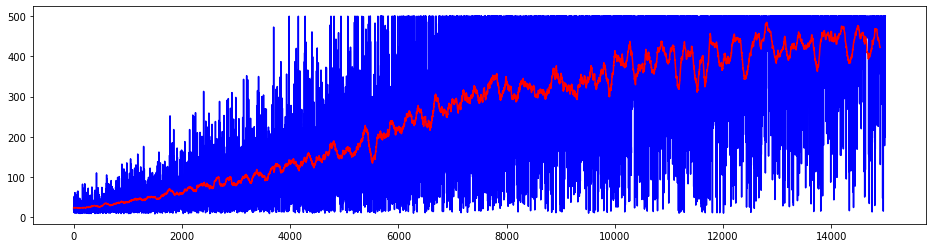

In [24]:
    # A set of parameters that is working well
    EPISODES       = 15000  # Number of eposides to run, org. val was only 1000, but that is way too little
    DISCRETE_STEPS = 20     # discretization steps per state variable (aviod odd numbers), org val = 10
    
    # Start with high EPSILON (and decreas in the code)
    EPSILON        = 1    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
    # These are "earlier best" and changed per run
    #GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9   
    LEARNING_RATE  = 0.5    # Learning rate, org val = 0.1

    GAMMA          = 0.98
    
    print("-------- Parameters ------------")

    print("EPISODES:",EPISODES)
    print("EPSILON:",EPSILON)
    print("GAMMA:",GAMMA)
    print("LEARNING_RATE:",LEARNING_RATE)
    print("DISCRETE_STEPS:",DISCRETE_STEPS)
    
        
        
    # (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
    average_cumulative_reward = 0.0

    episode_reward = np.zeros(EPISODES)
    # Create the Gym environment (CartPole)
    env = gym.make('CartPole-v1')

    print('Action space is:', env.action_space)
    print('Observation space is:', env.observation_space)

    # Q-table for the discretized states, and two actions
    num_states = DISCRETE_STEPS ** 4
    qtable = [[0., 0.] for state in range(num_states)]
    print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

    # Geron code
    alpha0 = 0.05
    decay = 0.005
    # gamma = 0.9
    state = 0
    # *** less epsilon decay
    decay = 0.0005


    # Loop over episodes
    # Code to make the training animated
    # https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
    for i in range(EPISODES):
                        
        # Tomas code
        state4D = env.reset()
        state = make_state(state4D)

        terminate = False
        cumulative_reward = 0.0

        # Loop over time-steps
        while not terminate:
            # Compute what the greedy action for the current state is
            qvalues = qtable[state]
            greedy_action = argmax(qvalues)

            # Sometimes, the agent takes a random action, to explore the environment
            # *** Use Epsilon-greedy with increasing probablility to choose max
            EP = EPSILON / (1 + i * decay)            
            if random.random() < EP:
                action = random.randrange(2)
            else:
                action = greedy_action

            
            
            # Perform the action
            next_state, reward, terminate, info = env.step(action)  # info is ignored
            next_state = make_state(next_state)
        
            # Show the simulated environment. A bit difficult to make it work.            
            # env.render()

            # Update the Q-Table - *** UPDATED CODE ***
            LR = LEARNING_RATE / (1 + i * decay)            
            td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
            qtable[state][action] += LR * td_error
            
            # Update statistics
            cumulative_reward += reward
            state = next_state

        # store reward for every episode
        episode_reward[i] = cumulative_reward
    
        # Adapt epsilon and learning rate here

        # Per-episode statistics
        if ((i % 500)==0):
          print(i, cumulative_reward, LR, EP, sep=',')

    print("---->>>> Check the Q-table (if a vector have 0.0 values, the it is not written below)")
    qvaluecount = 0
    cnt = 0
    for a,b in qtable:
        cnt = cnt + 1
        if a != 0.0 and b != 0.0:
            print ("vector nr:",cnt," values: ",a,",",b)
            qvaluecount = qvaluecount + 1
            
    print("Number of vectors in the q table:" , qvaluecount)
    
    
    print("-------- Done ------------")
    
    # Plot the results from a training run
    plt.figure(figsize=(16, 4))
    plt.plot(episode_reward,"b")
    y_av = running_mean(episode_reward, N=100)
    plt.plot(y_av,"r") 
    
    print("Average:",y_av)
    
    

Consistent reward value with the previous run
Average: [ 23.11  23.09  23.08 ... 421.98 421.98 422.05]

###### Analysis

    • För att bättre förstå, de troligen mediokra resultaten, undersöka Q-tabellen efter träningen
        ◦ Hur mycket av “världen” har systemet utforskat?
        ◦ Vad säger detta om Q-learning som metod
        ◦ kan du komma på något som skulle förbättra systemets prestanda och stabilitet.

In the first task we had mediocre results. In second tasks we had better but not good results. In the last search we got good results. If we look at the number of how much of the world that the model investigated looking at the number of vectors in the Q-table that have values we can see that the last models search much better.<br>
<br>
<b>Second search</b><br>
Average: [ 13.74  13.75  13.73 ... 134.86 134.73 134.03]	Number of vectors in the q table: 450<br>
Average: [ 11.34  11.35  11.32 ... 139.35 139.42 138.32]	Number of vectors in the q table: 238<br>
Average: [ 13.39  13.24  13.19 ... 173.63 173.74 173.84]	Number of vectors in the q table: 322<br>
Average: [ 10.63  10.63  10.66 ... 118.68 119.49 120.76]	Number of vectors in the q table: 319<br>
Average: [ 10.48  10.48  10.48 ... 145.85 144.91 145.07]	Number of vectors in the q table: 282<br>
Average: [ 10.68  10.69  10.72 ... 160.58 160.64 160.6 ]	Number of vectors in the q table: 406<br>
Average: [ 14.73  14.71  14.74 ... 167.08 166.95 166.45]	Number of vectors in the q table: 396<br>
<br>
<b>Last search</b><br>
Average: [ 23.91  23.85  23.93 ... 318.88 319.1  317.47]	Number of vectors in the q table: 1357<br>
Average: [ 21.67  21.7   21.6  ... 288.4  290.82 289.83]	Number of vectors in the q table: 1175<br>
Average: [ 23.18  22.96  22.91 ... 292.28 291.49 291.24]	Number of vectors in the q table: 1236<br>
Average: [ 21.87  21.87  21.9  ... 177.4  176.93 177.19]	Number of vectors in the q table: 967<br>
Average: [ 22.48  22.74  22.72 ... 358.49 356.84 354.84]	Number of vectors in the q table: 1244<br>
Average: [ 21.12  20.84  20.79 ... 272.92 271.34 270.74]	Number of vectors in the q table: 1259<br>
Average: [ 23.32  23.31  23.32 ... 421.66 422.99 424.5 ]	Number of vectors in the q table: 1259<br>
<br>

Having a high learning rate in the beginning that decreses over time together with greedy epsilon that "prefere" positive rewards over reandomness makes the model much better. Also rewarding previous steps more (higher gamma), contribute to the a better performing model


## VG part

Can be found in the repos here:<br>
